In [1]:
import os, sys, pathlib
os.chdir('/home/njm2149/Documents/datajoint-churchland/churchland_pipeline/users/njm2149')
sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[2]))
sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[2]) + '/brPY/')
import datajoint as dj
from churchland_pipeline import action, acquisition, equipment, lab, processing, reference
from churchland_pipeline.rigs.Jumanji import speedgoat
from churchland_pipeline.tasks.pacman import pacman_acquisition, pacman_processing
from churchland_pipeline.users.njm2149 import datajoint_utilities as dju
images_path = '/home/njm2149/Documents/datajoint-churchland/churchland_pipeline/images/'

Connecting ChurchlandLab_test@s1n4.u19motor.zi.columbia.edu:3306


In [2]:
import re, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from brpylib import NsxFile, brpylib_ver
from itertools import compress
import warnings
import timeit

%load_ext autoreload
%autoreload 2

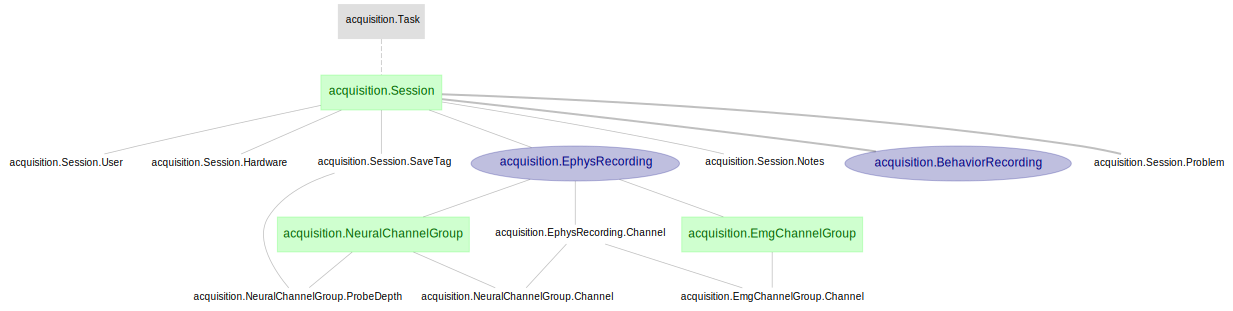

In [3]:
dj.ERD(acquisition)

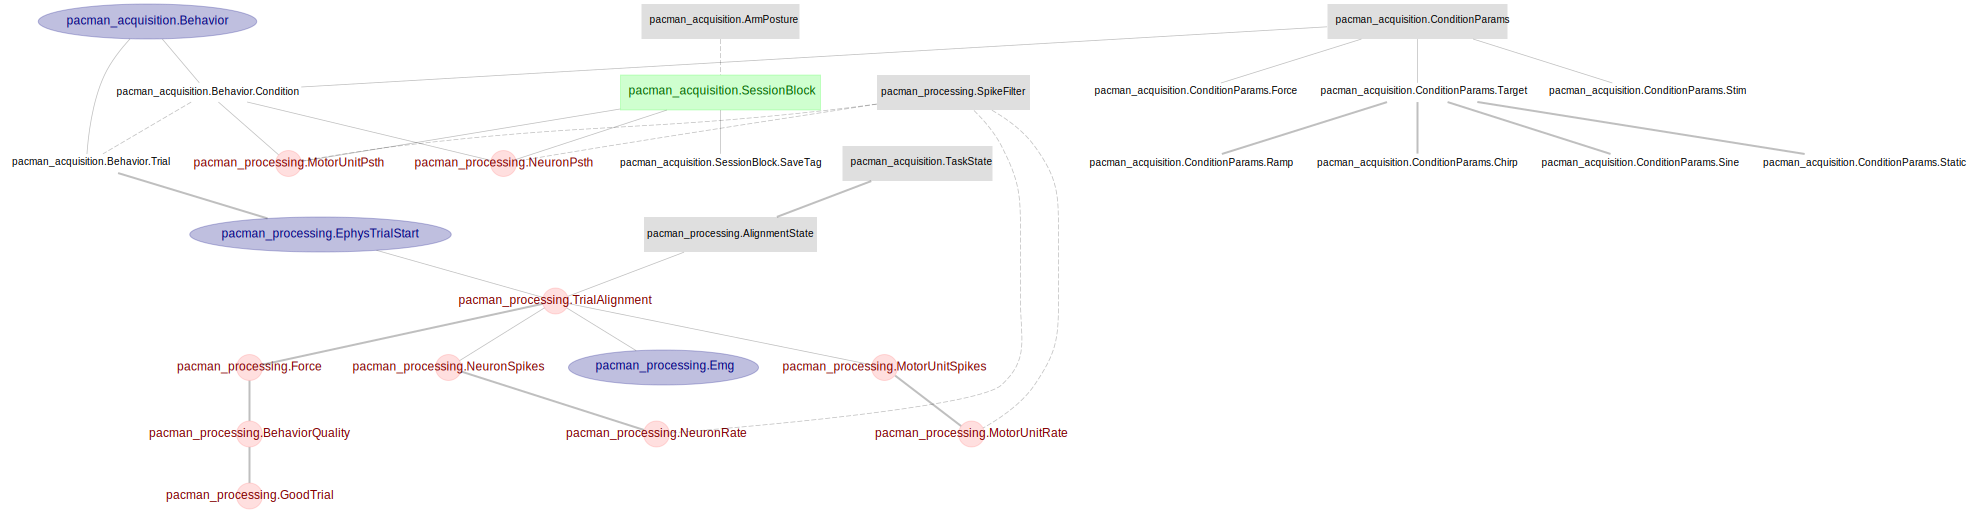

In [4]:
dj.ERD(pacman_acquisition) + dj.ERD(pacman_processing)

In [39]:
pacman_processing.EphysTrialStart.populate(display_progress=True)


  0%|          | 0/964 [00:00<?, ?it/s]
pacman-task_c_191216_neu_emg_001.ns6 opened

Output data requested is larger than 1 GB, attempting to preallocate output now

First data packet requested begins at t = 0.003400 s, initial section padded with zeros
Data extraction requires paging: 1 of 58
Data extraction requires paging: 2 of 58
Data extraction requires paging: 3 of 58
Data extraction requires paging: 4 of 58
Data extraction requires paging: 5 of 58
Data extraction requires paging: 6 of 58
Data extraction requires paging: 7 of 58
Data extraction requires paging: 8 of 58
Data extraction requires paging: 9 of 58
Data extraction requires paging: 10 of 58
Data extraction requires paging: 11 of 58
Data extraction requires paging: 12 of 58
Data extraction requires paging: 13 of 58
Data extraction requires paging: 14 of 58
Data extraction requires paging: 15 of 58
Data extraction requires paging: 16 of 58
Data extraction requires paging: 17 of 58
Data extraction requires paging: 18 of 5

In [41]:
pacman_processing.EphysTrialStart & {'session_date':'2019-12-16'}

session_date session date,monkey unique monkey name,trial_number trial number (within session),ephys_trial_start sample index (ephys time base) corresponding to the trial start
2019-12-16,Cousteau,1,1208483
2019-12-16,Cousteau,2,1417324
2019-12-16,Cousteau,3,1652958
2019-12-16,Cousteau,4,1885859
2019-12-16,Cousteau,5,2020626
2019-12-16,Cousteau,6,2317643
2019-12-16,Cousteau,7,2495521
2019-12-16,Cousteau,8,2697133
2019-12-16,Cousteau,9,2992198
2019-12-16,Cousteau,10,3098224


In [7]:
key = (acquisition.Session & {'session_date':'2019-12-16'}).fetch1('KEY')

# fetch trial numbers and simulation times
trial_num, trial_time = (pacman_acquisition.Behavior.Trial & key).fetch('trial_number', 'simulation_time')

# fetch sync signal
nsx_path = (acquisition.EphysRecording & key).fetch1('ephys_file_path')
sync_channel_id = (acquisition.EphysRecording.Channel & key & {'channel_label': 'sync'}).fetch1('channel_id')
nsx_file = NsxFile(nsx_path)
sync_channel = nsx_file.getdata(sync_channel_id)
nsx_file.close()


pacman-task_c_191216_neu_emg_001.ns6 opened

Output data requested is larger than 1 GB, attempting to preallocate output now

First data packet requested begins at t = 0.003400 s, initial section padded with zeros
Data extraction requires paging: 1 of 58
Data extraction requires paging: 2 of 58
Data extraction requires paging: 3 of 58
Data extraction requires paging: 4 of 58
Data extraction requires paging: 5 of 58
Data extraction requires paging: 6 of 58
Data extraction requires paging: 7 of 58
Data extraction requires paging: 8 of 58
Data extraction requires paging: 9 of 58
Data extraction requires paging: 10 of 58
Data extraction requires paging: 11 of 58
Data extraction requires paging: 12 of 58
Data extraction requires paging: 13 of 58
Data extraction requires paging: 14 of 58
Data extraction requires paging: 15 of 58
Data extraction requires paging: 16 of 58
Data extraction requires paging: 17 of 58
Data extraction requires paging: 18 of 58
Data extraction requires paging: 19 of

In [10]:
# --- VARIABLE ARGUMENTS
max_sample_err = 2
max_time_step = 0.2
# ---

# number of data samples
num_samples = sync_channel['data_headers'][0]['NumDataPoints']

# denoised sync signal
time_stamp = sync_channel['data_headers'][0]['Timestamp']
sync_signal = sync_channel['data'][0][time_stamp:] > sync_channel['data'][0][time_stamp:].mean()

# expected number of samples between sync signal edges based on timing code //TODO add more details about the timing code
samples_per_ms = int(sync_channel['samp_per_s']/1e3)
expected_pulse_len = dict(
    low           =       samples_per_ms,
    high          =   2 * samples_per_ms,
    inter_block   =   6 * samples_per_ms,
    dropped_block = 106 * samples_per_ms
    )

# indices of rising and falling edges in sync pulses
edge_idx = list(compress(range(num_samples), np.insert(np.diff(sync_signal),0,False)))

# samples between rising and falling edges
pulse_len = np.diff(edge_idx)
num_pulses = len(pulse_len)

# remove partial leading and trailing blocks
new_block = (pulse_len >= expected_pulse_len['inter_block'])
first_block_edge_start = next(compress(range(num_pulses), new_block))
last_block_edge_end = num_pulses-next(compress(range(num_pulses), np.flip(new_block)))
edge_idx = edge_idx[1+first_block_edge_start:last_block_edge_end]

# update record of pulse lengths
pulse_len = np.diff(edge_idx)
num_pulses = len(pulse_len)

# map each unique pulse length to closest expected length
nearest_expected_pulse_len = {unq_pulse_len: min(expected_pulse_len.values(), key=lambda x: abs(x-unq_pulse_len)) for unq_pulse_len in np.unique(pulse_len)}

# find the first pulse in each sync block
first_pulse = np.insert([nearest_expected_pulse_len[y] > expected_pulse_len['high'] for y in pulse_len],0,False)
first_pulse = np.insert(list(compress(range(num_pulses), first_pulse)),0,0)

# remove "first" pulses with insufficient data for a full time stamp
first_pulse = first_pulse[first_pulse+63 < num_pulses]

# extract timing code from sync blocks
new_block_idx = [edge_idx[i] for i in first_pulse]
sync_block = [dict(start=new_block_idx[i], code=pulse_len[first_pulse[i]+range(0,63,2)]) for i in range(len(new_block_idx))]

# check for corrupted sync blocks (if any pulse lengths deviates excessively from expected)
sync_block = ([dict(**d, corrupted=any(np.min(abs(d['code'] - np.array([[expected_pulse_len['low']],[expected_pulse_len['high']]])), axis=0) > max_sample_err)) for d in sync_block])

# decode sync blocks
pow_2 = [2**i for i in range(32)]
binary_code = [np.round((d['code'] - expected_pulse_len['low'])/expected_pulse_len['low']) if d['corrupted']==False else None for d in sync_block]
sync_block = [dict(**d, time=sum(bin_code * pow_2)/10 if d['corrupted']==False else np.nan) for d, bin_code in zip(sync_block, binary_code)]

# update list of corrupted blocks if any unusually large jumps in time
max_sim_time = sync_block[0]['time'] + sync_channel['data_time_s']
for i in range(1,len(sync_block)):
    if not (sync_block[i]['corrupted'] or sync_block[i-1]['corrupted']):
        sync_block[i].update(corrupted = (sync_block[i]['time']>sync_block[i-1]['time']+max_time_step) or sync_block[i]['time']>max_sim_time)

# throw warning for high proportions of corrupted sync blocks
p_corrupted = 100 * sum([sync_block[i]['corrupted'] for i in range(len(sync_block))])/len(sync_block)
if p_corrupted > 10:
    warnings.warn('{:.2f}% corrupted sync blocks. Timing estimate may be unreliable.'.format(p_corrupted))

# first sample index (ephys clock) when the sync block was first written to the file
ephys_block_idx = np.array([sync_block[i]['start'] for i in range(len(sync_block)) if not sync_block[i]['corrupted']])

# encoded time stamp (Speedgoat clock) associated with each sync block
speedgoat_block_time = np.array([sync_block[i]['time'] for i in range(len(sync_block)) if not sync_block[i]['corrupted']])

# trial start time (Speedgoat clock)
speedgoat_trial_start_time = [t[0] for t in trial_time]

# bin edges between ephys sample indices
ephys_block_idx_bins = np.concatenate((ephys_block_idx[:-1,np.newaxis], ephys_block_idx[1:,np.newaxis]), axis=1).mean(axis=1)
ephys_block_idx_bins = np.append(np.insert(ephys_block_idx_bins,0,0), np.Inf)

# bin edges between Speedgoat time stamp
speedgoat_block_time_bins = np.concatenate((speedgoat_block_time[:-1,np.newaxis], speedgoat_block_time[1:,np.newaxis]), axis=1).mean(axis=1)
speedgoat_block_time_bins = np.append(np.insert(speedgoat_block_time_bins,0,0), np.Inf)

# function to map ephys sample index to Speedgoat time base using a selected sync block
samp2time = lambda xi,sync_idx: round(speedgoat_block_time[sync_idx] + (xi-ephys_block_idx[sync_idx])/sync_channel['samp_per_s'], 6)

In [35]:
# preallocate array of trial start indices
ephys_trial_start_idx = np.empty(len(speedgoat_trial_start_time))

for i0,t0 in enumerate(speedgoat_trial_start_time):

    if t0 < speedgoat_block_time[0] or t0 > speedgoat_block_time[-1]:
        ephys_trial_start_idx[i0] = np.nan

    else:
        # find the sync block whose encoded time is nearest the trial start time
        nearest_block = np.digitize(t0, speedgoat_block_time_bins) - 1

        # sample index range containing the nearest sync block
        idx_range = range(\
            np.floor(ephys_block_idx_bins[nearest_block]).astype(int), \
            1+np.ceil(ephys_block_idx_bins[1+nearest_block]).astype(int))

        # nearest sample to the encoded trial start time
        ephys_trial_start_idx[i0] = next(i for i in idx_range if samp2time(i,nearest_block) >= t0)

# temporal correction
ephys_trial_start_idx = ephys_trial_start_idx - round(0.1 * sync_channel['samp_per_s'])

In [ ]:
# aggregate pipelines
Pipeline = {'common': dj.ERD(action) + dj.ERD(acquisition) + dj.ERD(equipment) + dj.ERD(lab) + dj.ERD(processing) + dj.ERD(reference),
            'pacman': dj.ERD(pacman_acquisition) + dj.ERD(pacman_processing),
            'emg': (dj.ERD(acquisition.EmgChannelGroup)-1) + (dj.ERD(processing.MotorUnit)-1),
            'neural': (dj.ERD(acquisition.NeuralChannelGroup)-1) + (dj.ERD(processing.Neuron)-1)}

### Questions

In [ ]:
"""
- remote debugging in VS Code?
"""

### Suggestions

In [ ]:
"""
insert a list of keys in acq.EphysRecording to improve performance
"""